# Adaptive Methods - Adjusting h

Differential equations can display highly variable behavior in different regions of the solution.  For some values of the dependent variable, there may be little change in most independent variables in the region.   For others, change can be extreme.  In this case, depending on what you desire for accuracy and run-time, it may not be optimal to have a single step-size.

This is the idea behind adaptive methods.  

## Half-Steps

One approach to adaptive methods is to propagate the solution forward by one step, h, and compare the result to what happens when you instead propagate the solution forward by two steps, each of size h/2.  This provides an estimate for any solver of the change in step error from changing step size.  The difference in these two is an estimate of your error.

As a result, if your compare your desired step error to the result calculated above, you can then adjust the step size down (to increase accuracy) or up (to reduce run-time) on the fly.

You might complain that you are calculating more points so why not just keep the h/2 step values?  One reason is that you often use the derivative function at the same values of the independent variable so do not have to evaluate f as many times as you might think.   So you are really not going through the full expense of propagating the solution in completely independent ways.

The second point is that you want to know the error.  The half step allows you to estimate the error on the full step, but you do not know the error associated with the half-step and it would be unwise to assume it is the same as the error on the full-step.  This is a common theme in these approaches.

One of the strengths of this technique is that it can be used with any solver.

## Runge-Kutta-Fehlberg (RKF45)

A more significant approach comes from a variation of the RK4 method.  It was discovered that a few calculations of f can provide the needed values to calculate both  an RK4 and and RK5 solution.  It is messy, but the approach is -


Each step requires the use of the following six values using the independent (t) and dependent (x) variables:
$$k_1 = hf(t_k,x_k)$$
$$k_2 = hf(t_k+\frac{1}{4}h,x_k+\frac{1}{4}k_1)$$
$$k_3 = hf(t_k+\frac{3}{8}h,x_k+\frac{3}{32}k_1+\frac{9}{32}k_2)$$
$$k_4 = hf(t_k+\frac{12}{13}h,x_k+\frac{1932}{2197}k_1-\frac{7200}{2197}k_2+\frac{7296}{2197}k_3)$$
$$k_5 = hf(t_k+h,x_k+\frac{439}{216}k_1-8k_2+\frac{3680}{513}k_3 - \frac{845}{4104}k_4)$$
$$k_6=hf(t_k+\frac{1}{2}h,x_k-\frac{8}{27}k_1+2k_2-\frac{3544}{2565}k_3 +\frac{1859}{4104}k_4-\frac{11}{40}k_5)$$

These values allow a calculation of both a 4-th order (O(h^5)) and 5-th order (O(h^6)) estimate of the new value.  The 4th-order estimate is - 
$$x_{k+1}=x_k+\frac{25}{216}k_1+\frac{1408}{2565}k_3 + \frac{2197}{4101}k_4-\frac{1}{5}k_5$$
The fifth-order estimate is -
$$z_{k+1}=x_k+\frac{16}{135}k_1+\frac{6656}{12825}k_3 + \frac{28561}{56430}k_4-\frac{9}{50}k_5+\frac{2}{55}k_6$$
and an estimate of the error in the 4-th order step is given by -
$$|z_{k+1}-x_{k+1}|$$

The optimal step size is then s*h where -
$$s=(\frac{tol\ h}{2|z_{k+1}-x_{k+1}|})^{1/4}$$
where "tol h" is the desired level of accuracy.  If s is less than 1, then the current step size is larger than necessary.  You can reduce the size for the next step and keep the currently calculated estimate of $x_{k+1}$.   

If s is greater than 1, the step size is too large to get the accuracy you desire.  Reduce h to the new value of s*h and re-calculate the step to improve the accuracy of the value.

**When you keep the results always use the RK4 result since it is the one for which you know the error.** While the RK5 result may seem more accurate, it is not always the case and what you want is a clear indicator of the step by step error.  If you care about the extra accuracy, just reduce your tolerance.  **One of the major advantages of adaptive methods is not necessarily better accuray, but rather reduced run time**

Here is the sequence of steps for the solver:
* Define initial conditions and initial time (t=t0) and duration (tdur)
* Start a loop that continues while t < tdur
* calculate the K1-K6 values within the loop
* Use these to calculate the trial RK5 (z) solution and RK4 (rtrial) solution
* Calculate the absolute deviation between the RK5 and RK4 solutions for all variables (array diffs)
* Define the largest deviation as the test case (usediff)
* Calculate the s value using usediff 
* If s is greater than 1, keep the step
    * set r=rtrial (RK4 result)
    * increment t
    * adjust h
* If s is less than 1, adjust h and retry the step without saving r or incrementing t
* Repeat as long as t < tdur (or tend)}


In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def myf(r,t,omega0sqr,omegad,beta,gamma):
    theta=r[0]
    omega=r[1]
    dtheta = omega
    domega=-2*beta*omega -omega0sqr*np.sin(theta) + gamma*omega0sqr*np.cos(omegad*t)
    return np.array([dtheta,domega],float)

def ddho(omega0,omegad,beta,gamma,inittheta,initomega,tdur,dt):
    a20=1./4.
    a21=1./4.
    a30=3./8.
    a31=3./32.
    a32=9./32.
    a40=12./13.
    a41=1932./2197.
    a42=-7200./2197.
    a43=7296./2197.
    a50=1.0
    a51=439./216.
    a52=-8.
    a53=3680./513.
    a54=-845./4104.
    a60=1./2.
    a61=-8./27.
    a62=2.0
    a63=-3544./2565.
    a64=1859./4104.
    a65=-11./40
    
    rk1=25./216.
    rk3=1408./2565.
    rk4=2197./4104.
    rk5=-1./5.
    zk1=16./135.
    zk3=6656./12825.
    zk4=28561./56430.
    zk5=-9./50.
    zk6=2./55.

    tol = 1.0e-6
    t=0.
    h = dt       # initial step size
    #no longer use number of steps N = tdur/dt          # Number of steps
    omega0sqr=omega0*omega0

#create the array of time values and (empty) omega and theta-values, and loop over 
#all times supplementing x each time
    #times = np.arange(0,tdur,h)
    times  = []
    theta4 = []
    omega4 = []
#    delta = []
#    harray = []

    r = np.array([inittheta,initomega],float)   #initial conditions for omega,theta, r is current value vector
#all steps are as normal RK4, but vector valued quantities used
    while t <= tdur:

        k1 = h*myf(r,t,omega0sqr,omegad,beta,gamma)
        k2 = h*myf(r+a21*k1,t+a20*h,omega0sqr,omegad,beta,gamma)
        k3 = h*myf(r+a31*k1+a32*k2,t+a30*h,omega0sqr,omegad,beta,gamma)
        k4 = h*myf(r+a41*k1+a42*k2+a43*k3,t+a40*h,omega0sqr,omegad,beta,gamma)
        k5 = h*myf(r+a51*k1+a52*k2+a53*k3+a54*k4,t+a50*h,omega0sqr,omegad,beta,gamma)
        k6 = h*myf(r+a61*k1+a62*k2+a63*k3+a64*k4+a65*k5,t+a60*h,omega0sqr,omegad,beta,gamma)
        
        z = r + zk1*k1+zk3*k3+zk4*k4+zk5*k5+zk6*k6
        rtrial = r+rk1*k1+rk3*k3+rk4*k4+rk5*k5
        diffs=abs(z-rtrial)
        usediff=diffs[0]
        if usediff !=0:
            s=0.84*(tol/usediff)**(0.25)
        else:
            s=1.
        if s>1.0:
            r=rtrial
            t=t+h
            times.append(t)
            theta4.append(r[0])
            omega4.append(r[1])
            h=s*h
        else:
            h=s*h
            
    plt.plot(times,theta4,label='theta')
    #plt.plot(times,omega,label='omega')
    plt.title("Example RK4 Solution for damped, driven harmonic oscillator")
    plt.xlabel("t")
    plt.xlabel("displacement (thta)")

    #plt.legend(loc='upper right')
#plt.ylabel("x(t)")
    plt.show()
    return times,theta4,omega4

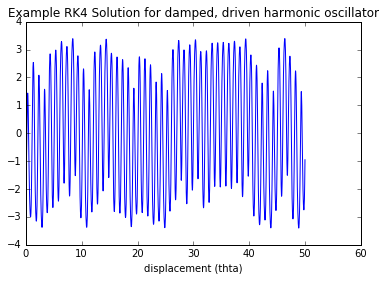

In [4]:
#def ddho(omega0,omegad,beta,gamma,inittheta,initomega,tdur,dt)
(times,theta,omega)=ddho(3*np.pi,2*np.pi,0.75*np.pi,1.105,-np.pi/2.,0.0,50,0.1)

In [5]:
delta=np.zeros(len(times))
for i in range(1,len(times)):
        delta[i]=times[i]-times[i-1]

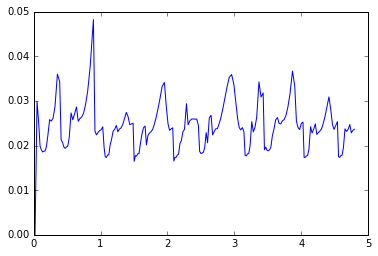

In [6]:
plt.plot(times[0:200],delta[0:200])